In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

## Import Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.layers.merge import concatenate
from keras.layers import Input
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D, Flatten,Conv2D, Dense,BatchNormalization,GlobalAveragePooling2D,Dropout, Flatten
from tensorflow.keras.applications.densenet import DenseNet169
%matplotlib inline



In [3]:


# create directory variables for easy access to data
main_dir = '../input/chest-xray-pneumonia/chest_xray/'
train_data_dir = main_dir + 'train/'
validation_data_dir = main_dir + 'val/'
test_data_dir = main_dir + 'test/'
train_n = train_data_dir + 'NORMAL/'
train_p = train_data_dir + 'PNEUMONIA/'



In [4]:
# Split the images into normal and pneumonia
normal_images = [fn for fn in os.listdir(train_n) if fn.endswith('.jpeg')]
pneumonia_images = [fn for fn in os.listdir(train_p) if fn.endswith('.jpeg')]



## Create a Data Generator

In [5]:
train_datagen = ImageDataGenerator(rescale= 1./255)
test_datagen = ImageDataGenerator(rescale= 1./255)
val_datagen = ImageDataGenerator(rescale= 1./255)

### Load the Data into the Data Generator

In [6]:
img_width, img_height = [224, 224]
batch_size = 16

In [7]:
# load the training data generator
train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    class_mode='binary',
                    shuffle=True)

Found 5216 images belonging to 2 classes.


In [8]:
# load the validation data generator
validation_generator = val_datagen.flow_from_directory(
                    validation_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    class_mode='binary',
                    shuffle=True)

Found 16 images belonging to 2 classes.


In [9]:
# load the testing data generator
test_generator = test_datagen.flow_from_directory(
                    test_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    class_mode='binary',
                    shuffle=True)

Found 624 images belonging to 2 classes.


## Plot Images from the Data Generator

In [10]:
# iterate through the generator of training images
image_batch, label_batch = next(iter(train_generator))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    
    # iterate through 10 images
    for n in range(10):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

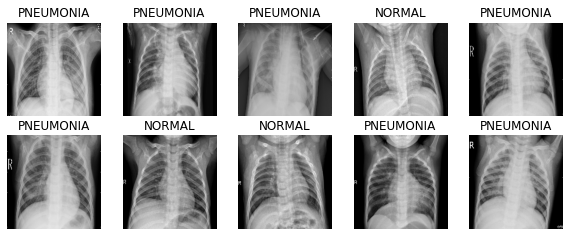

In [11]:
# display 10 images of training batch
show_batch(image_batch, label_batch)

## Build DenseNet169 Model for Baseline Performance

In [12]:
input_shape = (224, 224, 3)
input_layer = Input(shape = (224, 224, 3))

In [13]:
# baseline densenet model
densenet_base = DenseNet169(
                        weights = 'imagenet',
                        input_shape = input_shape,
                        include_top = False
                        )


2022-05-18 01:22:55.121909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 01:22:55.249730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 01:22:55.250535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 01:22:55.251938: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

51888128/51877672 [==============================] - 0s 0us/step


In [14]:
# freeze the layers of the base model
for layer in densenet_base.layers:
    layer.trainable = False

In [15]:
# view the model architecture
densenet_base.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

#### This is a large model with a lot of layers. All the layers are frozen and won't be trained for this baseline.

#### An Output Layer with a sigmoid activation needs to added to the model

In [16]:
# create the output layer with one node and use sigmoid activation
densenet_model = Sequential()
densenet_model.add(densenet_base)
densenet_model.add(Flatten())
densenet_model.add(Dense(activation='sigmoid', units = 1))

## Run the Model

Use Adam optimizer and learning rate of 0.0001

In [17]:
optm = Adam(learning_rate=0.0001)
densenet_model.compile(
                    loss='binary_crossentropy',
                    optimizer=optm,
                    metrics=['accuracy'])

In [18]:
# create call backs for early stopping
from keras.callbacks import EarlyStopping
EarlyStopping = EarlyStopping(
                            monitor='val_accuracy',
                            min_delta=.01,
                            patience=6,
                            verbose=1,
                            mode='auto',
                            baseline=None,
                            restore_best_weights=True)

In [19]:
from keras.callbacks import ModelCheckpoint

model_save = ModelCheckpoint('./densenet169_baseline.h5',
                            save_best_only = True,
                            save_weights_only = False,
                            monitor = 'val_loss',
                            mode = 'min',
                            verbose = 1)

## Training the Model

In [20]:
nb_train_samples = 5216
nb_validation_samples = 16
nb_test_sampels = 624
epochs = 20
batch_size = 16

In [22]:
densenet_history = densenet_model.fit(train_generator,
                                    steps_per_epoch = nb_train_samples//batch_size,
                                    epochs = epochs,
                                    validation_data = test_generator,
                                    callbacks = [EarlyStopping, model_save])
                        

2022-05-18 01:23:19.371612: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-05-18 01:23:28.031464: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


326/326 [==============================] - 123s 333ms/step - loss: 0.1182 - accuracy: 0.9532 - val_loss: 0.6287 - val_accuracy: 0.7997

Epoch 00001: val_loss improved from inf to 0.62875, saving model to ./densenet169_baseline.h5
Epoch 2/20
326/326 [==============================] - 71s 217ms/step - loss: 0.0401 - accuracy: 0.9887 - val_loss: 0.4788 - val_accuracy: 0.8558

Epoch 00002: val_loss improved from 0.62875 to 0.47884, saving model to ./densenet169_baseline.h5
Epoch 3/20
326/326 [==============================] - 72s 220ms/step - loss: 0.0252 - accuracy: 0.9927 - val_loss: 0.6748 - val_accuracy: 0.8301

Epoch 00003: val_loss did not improve from 0.47884
Epoch 4/20
326/326 [==============================] - 70s 215ms/step - loss: 0.0146 - accuracy: 0.9973 - val_loss: 1.0261 - val_accuracy: 0.7644

Epoch 00004: val_loss did not improve from 0.47884
Epoch 5/20
326/326 [==============================] - 71s 218ms/step - loss: 0.0090 - accuracy: 0.9988 - val_loss: 0.9889 - val_accu